In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def waterfall_plot(ez_plots, epsR, res, time_points, rel_source_pos):
    '''Waterfall ploting for the simulations. Can plot multiple variations.'''
    # Create waterfall plot axis
    xsize = len(ez_plots[0][0])
    source_pos = math.floor(rel_source_pos*xsize)
    fig, ax = plt.subplots(figsize=(12, 10))
    #Downsampling to speed up if grid is too fine
    if res >= 10:
        x_downsample = math.floor(res / 10)
    else:
        x_downsample = 1

    x = np.arange(xsize) 
    vertical_offset = 2.0  # Vertical spacing between traces
    total_height = len(ez_plots[0]) * vertical_offset
    # epsR background with alpha scaled by relative permittivity 

    epsR_norm = (epsR - 1.0) / (epsR.max() - 1.0)   # epsR=1 → 0, max → 1
    total_height = len(ez_plots[0]) * vertical_offset
    epsR_plot = epsR_norm[::x_downsample]
    x_plot = x[::x_downsample]

    for i in range(len(x_plot) - 1): 
        if epsR_plot[i] > 0:
            ax.fill_between([x_plot[i], x_plot[i+1]], 0, total_height, color='orange', alpha=0.25 * epsR_plot[i], linewidth=0)

    color_ind = 0
    cmap = plt.get_cmap("viridis")
    for ez_history in ez_plots:
        color = cmap(color_ind / (len(ez_plots)))
        # Plot each time step offset vertically
        for i, (t, ez_snapshot) in enumerate(zip(time_points, ez_history)):
            # Offset each trace vertically
            y_offset = i * vertical_offset
            ax.plot(x[::x_downsample], ez_snapshot[::x_downsample] + y_offset, color = color, linewidth=0.8, alpha=0.7)
            
            # Optional: add baseline for each trace
            #ax.axhline(y=y_offset, color='gray', linewidth=0.3, alpha=0.3, linestyle='--')
            
            # Optional: label some time steps on the right
            if i % 5 == 0:  # Label every 5th trace
                ax.text(xsize + 2, y_offset, f't={t}', fontsize=8, va='center')
        color_ind += 1
        
    # Mark source location
    ax.axvline(x=source_pos, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Source (x=50)')
    
    ax.set_xlabel('Position', fontsize=12)
    ax.set_ylabel('Time →', fontsize=12)
    ax.set_title('Stacked Waterfall Plot - FDTD Ez Field', fontsize=14)
    ax.set_xlim(0, xsize)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.2)

    plt.tight_layout()
    #plt.savefig('fdtd_stacked_waterfall.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Waterfall Plot Generated")


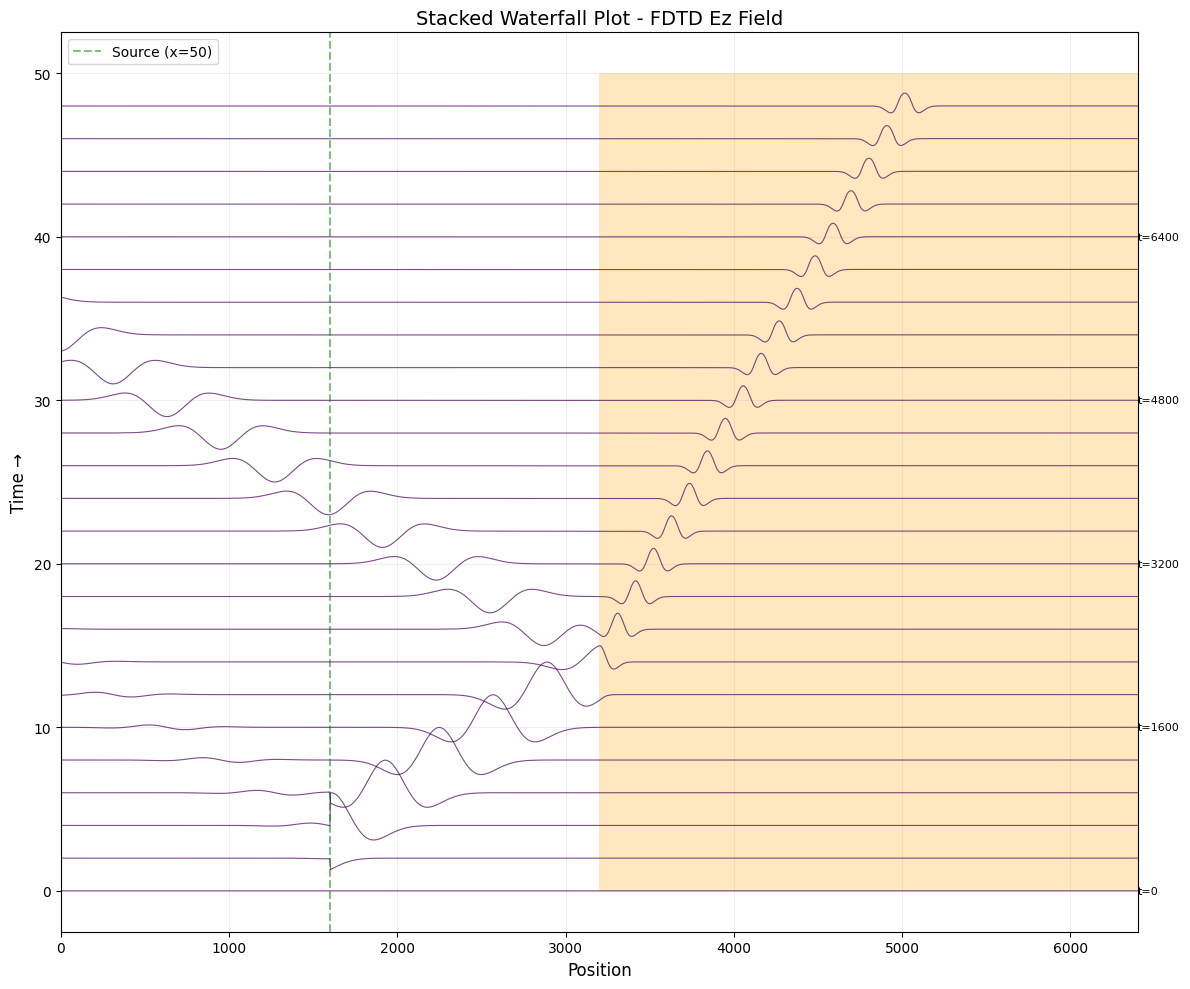

Waterfall Plot Generated


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# All of the physical parameters. Changing these changes the situation being simulated
# Physical simulation parameters
SIZE = 200
IMP0 = 377.0
MAX_TIME = 250

# Ricker wavelet parameters
FREQ_C = 0.05  # Central frequency (cycles per grid point/time step)
T0 = 1.0 / FREQ_C  # Pulse delay
AMPLITUDE = 2.0
RELATIVE_SOURCE_POS = 0.25



#Ricker wavelet source (resolution invariant)
def ricker_wavelet(t, f_c=FREQ_C, amp = AMPLITUDE):
    pi2 = (np.pi * f_c * t)**2
    return amp * (1 - 2 * pi2) * np.exp(-pi2)

def generate_grid(struct = "simple_barrier", res = 1, nonlin = False):
    '''Generates epsilon distribution'''
    xsize = math.floor(SIZE*res)

    ez = np.zeros(xsize)
    hy = np.zeros(xsize)
    alpha = np.zeros(xsize)
    epsR = np.ones(xsize)
    if struct == "simple_barrier":
        sep = math.floor(xsize * .5)
        epsR[sep:] = 9
        if nonlin == True:
            alpha[sep:] = 0.001 # Change this to ramp up nonlinearities
            
    if nonlin == False:
        alpha = np.zeros(xsize)

    return ez, hy, epsR, alpha, res

def fdtd_tfsf(ez, hy, epsR, alpha, res = 1, rel_source_pos = RELATIVE_SOURCE_POS, bound_cond = "1ABC", plot=False, nonlin = False, small_nonlin = True):
    
    '''Core FDTD Engine. res is a resolution multiplier. nonlin adds Kerr nonlinearity update. When small linear is false the cubic will be solved explicitly (takes much longer)'''
    
    tsize = math.floor(MAX_TIME * res)
    xsize = math.floor(SIZE * res)
    source_pos = math.floor(rel_source_pos*xsize)
    # Store field history for plotting
    downsample = tsize // 25 # Store every 10th time step to reduce clutter
    ez_history = []
    time_points = []
    epsRe = epsR.copy() #Effective epsilon
    for qTime in range(tsize):
        t = qTime / res #Adjusts source based on resolution for invariance
        # ABC for hy
        hy[-1] = hy[-2]
        
        # Update magnetic field (vectorized)
        hy[:-1] += (ez[1:] - ez[:-1]) / IMP0

        # TFSF Correction
        hy[source_pos-1] -= ricker_wavelet(t - T0) / IMP0
        
        # ABC for ez
        ez[0] = ez[1]
        
        if nonlin == True:
            if small_nonlin == True: #Approximation for small linearities
                epsRe[1:] = epsR[1:] + alpha[1:] * ez[1:]**2
                # Update electric field (vectorized)
                ez[1:] += (hy[1:] - hy[:-1]) * IMP0 / epsRe[1:]
            else:
                # True Kerr: solve cubic eps_r(E) * E = D for all points (complicated slow thing to do)

                # Compute D (Ez at next step if explicit, or you can include curl(H) term)
                D = epsR[1:] * ez[1:] + (hy[1:] - hy[:-1]) * IMP0

                # Initial guess for E: previous Ez
                E = ez[1:].copy()

                # Newton-Raphson iteration
                max_iter = 20
                tol = 1e-12

                for _ in range(max_iter):
                    f = alpha[1:] * E**3 + epsR[1:] * E - D        # cubic: alpha E^3 + epsR0 E - D = 0
                    df = 3 * alpha[1:] * E**2 + epsR[1:]          # derivative
                    delta = f / df
                    E -= delta
                    if np.all(np.abs(delta) < tol):
                        break

                ez[1:] = E
        else:
            ez[1:] += (hy[1:] - hy[:-1]) * IMP0 / epsR[1:]
        
        # TFSF correction
        ez[source_pos] += ricker_wavelet(t + 0.5 - T0)
        
        # Store snapshots
        if qTime % downsample == 0:
            ez_history.append(ez.copy())
            time_points.append(qTime)

    if plot == True:
        ezlist = []
        ezlist.append(ez_history)
        waterfall_plot(ezlist, epsR, res, time_points, rel_source_pos)

    return ez, hy, ez_history, time_points

if __name__ == "__main__":
    ez, hy, epsR, alpha, res = generate_grid(res=32, nonlin=True)
    fdtd_tfsf(ez = ez, hy=hy, epsR=epsR, alpha=alpha, res=res, plot=True, nonlin= True, small_nonlin=False)

Max resolution: 64


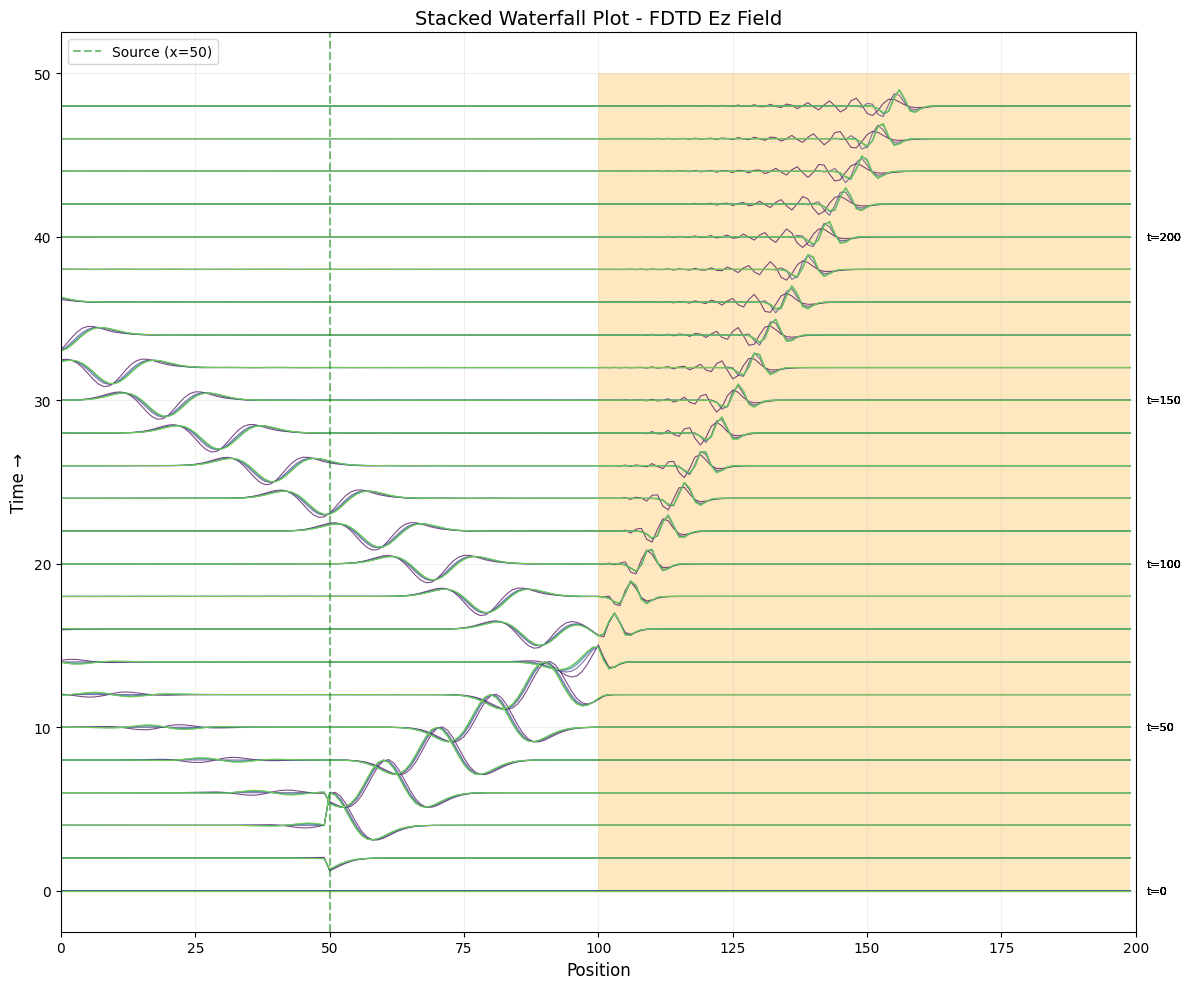

Waterfall Plot Generated
Orders: [1.0222874836077727, 1.9598028028158345, 2.2957534786854428, 2.4572026890940823]
Average Order: 1.9337616135507831


1.9337616135507831

In [174]:
from scipy.interpolate import interp1d
def convergence_test(min_res = 1, sample_points = 6, r = 2, struct = "simple_barrier", nonlin = False): # keep r greater than 2, min res greater than 1
    print(f"Max resolution: {(min_res*(r**sample_points))}")
    ez_samples = []
    ez_plots = []
    
    

    for n in range(sample_points):
        ez, hy, epsR, alpha, res = generate_grid(res=(min_res * (r**n)), nonlin= nonlin)
        ez, hy, ez_history, times = fdtd_tfsf(ez, hy, epsR, alpha, res, plot=False, nonlin=nonlin)
        if n == 0:
            time_points = times
            epsR_plot = epsR
        ez_samples.append(ez)
        ez_plots.append(ez_history)
        
        

    ez_coarse = []
    x_coarse = np.linspace(0, 1, len(ez_samples[0])) 
    for plot in ez_plots:
        for i in range(len(plot)):
            x_fine = np.linspace(0, 1, len(plot[i])) 
            interp_func = interp1d(x_fine, plot[i], kind='linear')
            plot[i] = interp_func(x_coarse)

    waterfall_plot(ez_plots, epsR_plot, res = min_res, time_points=time_points, rel_source_pos=RELATIVE_SOURCE_POS)

    for sample in ez_samples:
        x_fine = np.linspace(0, 1, len(sample))
        interp_func = interp1d(x_fine, sample, kind='linear')
        ez_coarse.append(interp_func(x_coarse))

    def l2_error(reference, solution):
        return np.sqrt(np.mean((solution - reference)**2))
    
    orders = []
    
    for i in range(sample_points-2):
        sample_order = np.log(l2_error(ez_coarse[i], ez_coarse[i+1]) / l2_error(ez_coarse[i+1], ez_coarse[i+2])) / np.log(r)
        orders.append(sample_order)
        i += 1

    avg_order = np.mean(orders)
    print(f"Orders: {orders}")
    print(f"Average Order: {np.mean(orders)}")

    return avg_order
    
convergence_test(nonlin=True)